In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
C = torch.randn((27, 5))

In [7]:
emb = C[Xtr] # embed each character index in the sequence Xtr

In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
# Kaiming initialization for weights and zero initialization for biases
W1 = torch.nn.init.kaiming_normal_(torch.empty((60, 300)), nonlinearity='tanh')
b1 = torch.zeros(300)
W2 = torch.nn.init.kaiming_normal_(torch.empty((300, 27)), nonlinearity='tanh')
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)
for p in parameters:
  p.requires_grad = True

In [19]:
num_iter = 600000
lossi=[]
stepi = []

In [20]:
for i in range(num_iter):
    ix = torch.randint(0, Xtr.shape[0], (64,)) # indices for batch of 32 random samples
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # forward pass
    emb = C[Xb] # embed each character index in the sequence Xb
    h = torch.tanh((emb.view(-1,60) @ W1) + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    lr = 0.1 * 0.5**(i//100000)
    # lr = 0.01
    for p in parameters:
      p.data += -lr * p.grad
    
    lossi.append(loss.log10().item())
    stepi.append(i)


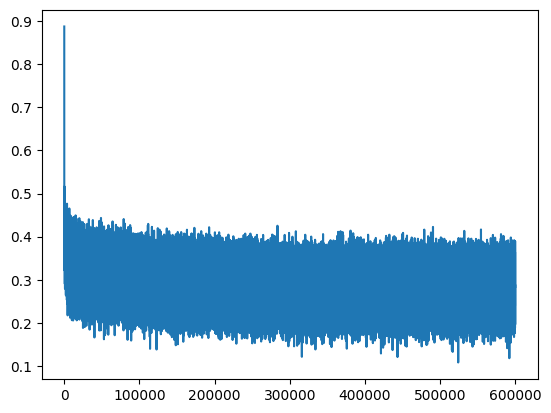

In [21]:
plt.plot(stepi, lossi)

In [22]:
emb = C[Xtr]
h = torch.tanh((emb.view(-1,60) @ W1) + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('train loss:', loss.item())

train loss: 1.9268405437469482


In [23]:
emb = C[Xdev]
h = torch.tanh((emb.view(-1,60) @ W1) + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss.item())

dev loss: 2.092555046081543


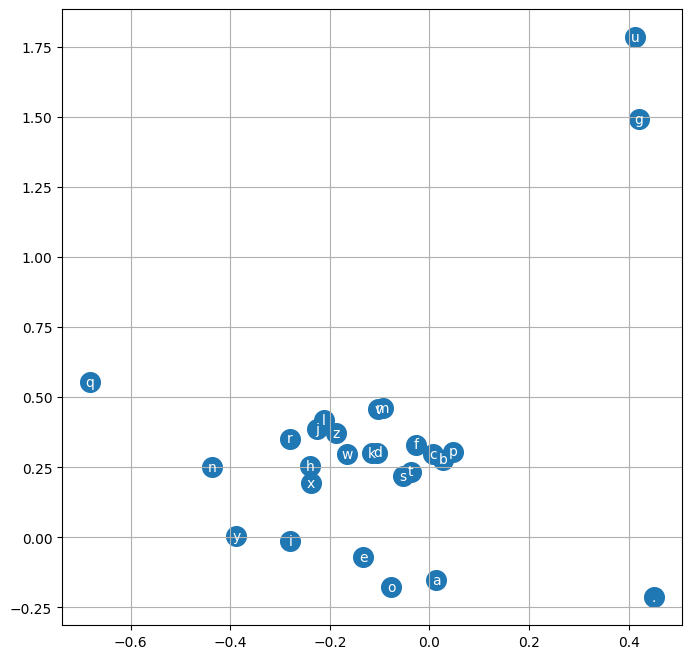

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# this is just for 2 dimensional character embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrmin.
reity.
skanden.
jazzmin.
deliah.
jareen.
nellara.
chaily.
kaleigh.
ham.
joce.
quintis.
lilah.
jadilyn.
jermaijaryn.
kai.
evells.
brex.


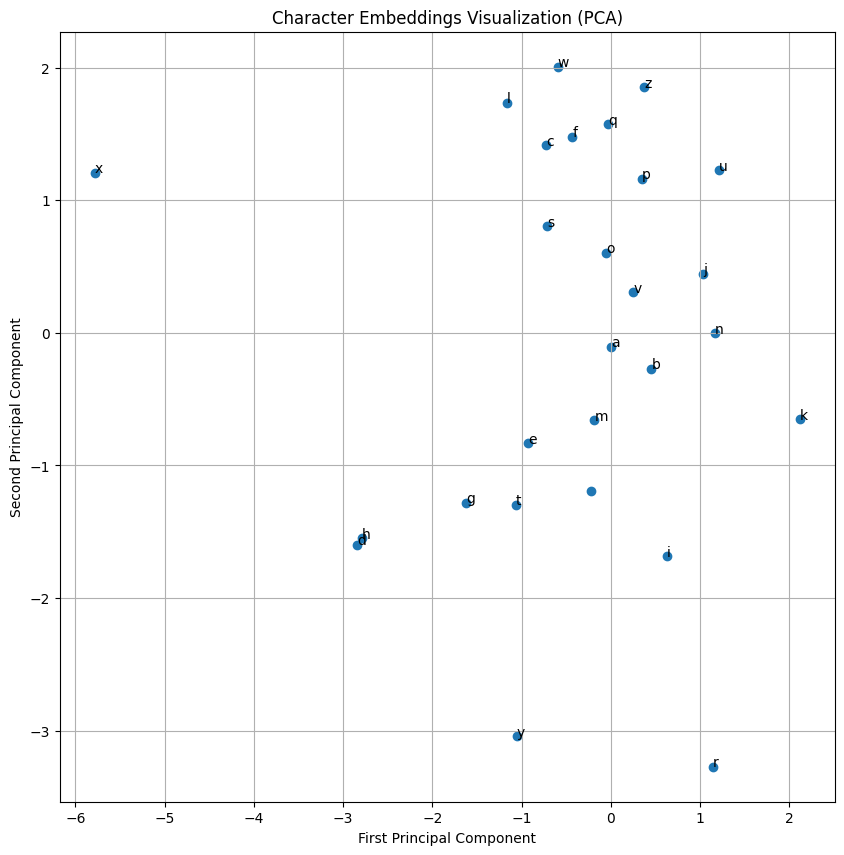

In [25]:
# trying to visualize the character embeddings for high dimensional embeddings
# using PCA


embeddings = C

# Compute PCA using SVD (singular value decomposition)
U, S, V = torch.pca_lowrank(embeddings, q=2)
embeddings_2d = embeddings @ V[:, :2]

# Create the scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0].detach(), embeddings_2d[:, 1].detach())

# Add labels for each point
chars_list = list('abcdefghijklmnopqrstuvwxyz')
for i, char in enumerate(chars_list):
    plt.annotate(char, (embeddings_2d[i, 0].item(), embeddings_2d[i, 1].item()))

plt.title('Character Embeddings Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
